# 🔥 MEGA RAG EVALUATION ANALYSIS 🔥

**Comprehensive analysis of RAG pipeline performance across different chunking strategies, retrieval modes, and reranking approaches.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# === CORPUS CONFIGURATION ===
CORPUS_NAME = "Washington"  # Change to "eu_geschichte" (or your folder name) for the second corpus

# Metrics to analyze
METRICS = ['context_precision', 'faithfulness', 'answer_relevancy', 'context_recall', 
           'answer_correctness', 'answer_similarity', 'factuality_score']
           
BASELINE_METHOD = 'hybrid_semantic_rerank'  # Our reference method

In [3]:
# Absolute baseline removed — dense_recursive (F=0.724) serves as the effective baseline.
# Steinmaurer's reported F=0.84 was on Einstein with 200 auto-generated questions (not comparable).
# The no-chunking baseline (F=0.618) was from old buggy runs and is no longer used.

EFFECTIVE_BASELINE = 'dense_recursive'  # Same architecture as predecessor (Steinmaurer)
print(f"Effective baseline pipeline: {EFFECTIVE_BASELINE}")

Effective baseline pipeline: dense_recursive


In [4]:
# 📊 DATA LOADING & PREPROCESSING
def load_all_results(results_dir=None):
    """Load all pipeline results into a combined DataFrame.
    Only loads from final_run_42Q/ (the 12 main pipelines).
    Chunk-size experiment CSVs are loaded separately.
    """
    if results_dir is None:
        results_dir = f'./results/{CORPUS_NAME}/final_run_42Q/'
    
    import glob as glob_module
    files = glob_module.glob(f"{results_dir}*_final_results.csv")
    
    all_data = []
    for file in files:
        method_name = file.replace('\\', '/').split('/')[-1].replace('_final_results.csv', '')
        df = pd.read_csv(file)
        df['method'] = method_name
        
        if 'dense' in method_name:
            df['retrieval_mode'] = 'dense'
        else:
            df['retrieval_mode'] = 'hybrid'
            
        if 'recursive' in method_name:
            df['chunking_strategy'] = 'recursive'
        elif 'sentence' in method_name:
            df['chunking_strategy'] = 'sentence_transformer'
        elif 'semantic' in method_name:
            df['chunking_strategy'] = 'semantic'
            
        df['has_reranker'] = 'rerank' in method_name
        
        # Normalize column name: some CSVs have semantic_similarity, others answer_similarity
        if 'semantic_similarity' in df.columns and 'answer_similarity' not in df.columns:
            df = df.rename(columns={'semantic_similarity': 'answer_similarity'})
        
        all_data.append(df)
    
    combined = pd.concat(all_data, ignore_index=True)
    print(f"📈 Loaded {len(files)} methods, {len(combined)} total evaluations")
    print(f"📋 Methods: {sorted(combined['method'].unique())}")
    print(f"🎯 Question types: {combined['question_type'].value_counts().to_dict()}")
    
    return combined

def load_chunk_experiment(results_dir=None):
    """Load chunk-size experiment results separately."""
    if results_dir is None:
        results_dir = f'./results/{CORPUS_NAME}/chunk_size_experiment/'
    
    import glob as glob_module
    files = glob_module.glob(f"{results_dir}*_final_results.csv")
    if not files:
        print("⚠️ No chunk-size experiment CSVs found.")
        return pd.DataFrame()
    
    all_data = []
    for file in files:
        method_name = file.replace('\\', '/').split('/')[-1].replace('_final_results.csv', '')
        df_chunk = pd.read_csv(file)
        df_chunk['method'] = method_name
        if 'semantic_similarity' in df_chunk.columns and 'answer_similarity' not in df_chunk.columns:
            df_chunk = df_chunk.rename(columns={'semantic_similarity': 'answer_similarity'})
        all_data.append(df_chunk)
    
    combined = pd.concat(all_data, ignore_index=True)
    print(f"📈 Chunk experiment: Loaded {len(files)} methods, {len(combined)} total evaluations")
    return combined

# Load main 12 pipelines
df = load_all_results()

# Load chunk-size experiment separately
df_chunk = load_chunk_experiment()

📈 Loaded 12 methods, 504 total evaluations
📋 Methods: ['dense_recursive', 'dense_recursive_rerank', 'dense_semantic', 'dense_semantic_rerank', 'dense_sentence', 'dense_sentence_rerank', 'hybrid_recursive', 'hybrid_recursive_rerank', 'hybrid_semantic', 'hybrid_semantic_rerank', 'hybrid_sentence', 'hybrid_sentence_rerank']
🎯 Question types: {'single_hop_specifc_query_synthesizer': 168, 'multi_hop_abstract_query_synthesizer': 168, 'multi_hop_specific_query_synthesizer': 168}
📈 Chunk experiment: Loaded 9 methods, 378 total evaluations


## 🎯 1. CORE PERFORMANCE ANALYSIS

In [5]:
# 📊 METHOD PERFORMANCE SUMMARY
def performance_summary_table():
    """Create comprehensive performance summary with means, ranks, and confidence intervals"""
    
    summary_data = []
    
    for method in sorted(df['method'].unique()):
        method_data = df[df['method'] == method]
        row = {'Method': method}
        
        for metric in METRICS:
            if metric not in method_data.columns:
                continue
            values = method_data[metric].dropna()
            if len(values) > 0:
                mean_val = values.mean()
                std_val = values.std()
                
                # 95% Confidence Interval
                ci = stats.t.interval(0.95, len(values)-1, 
                                     loc=mean_val, 
                                     scale=stats.sem(values))
                
                row[f'{metric}_mean'] = mean_val
                row[f'{metric}_std'] = std_val
                row[f'{metric}_ci_lower'] = ci[0]
                row[f'{metric}_ci_upper'] = ci[1]
                row[f'{metric}_formatted'] = f"{mean_val:.3f} ± {std_val:.3f}"
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calculate ranks (1 = best)
    for metric in METRICS:
        if f'{metric}_mean' in summary_df.columns:
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
    
    return summary_df

summary = performance_summary_table()

# Display core metrics table
display_cols = ['Method'] + [f'{metric}_formatted' for metric in METRICS[:4] 
                              if f'{metric}_formatted' in summary.columns]
print("CORE METRICS SUMMARY (Mean ± Std)")
print("=" * 80)
print(summary[display_cols].to_string(index=False))

# Display ranks
rank_cols = ['Method'] + [f'{metric}_rank' for metric in METRICS[:4]
                           if f'{metric}_rank' in summary.columns]
print("\nPERFORMANCE RANKS (1 = Best)")
print("=" * 60)
print(summary[rank_cols].to_string(index=False))

# Highlight effective baseline
baseline_faith = df[df['method'] == EFFECTIVE_BASELINE]['faithfulness'].mean()
print(f"\nEffective baseline ({EFFECTIVE_BASELINE}): F={baseline_faith:.3f}")

CORE METRICS SUMMARY (Mean ± Std)
                 Method context_precision_formatted faithfulness_formatted answer_relevancy_formatted context_recall_formatted
        dense_recursive               0.944 ± 0.140          0.724 ± 0.347              0.869 ± 0.246            0.670 ± 0.465
 dense_recursive_rerank               0.980 ± 0.055          0.747 ± 0.372              0.862 ± 0.245            0.860 ± 0.322
         dense_semantic               0.935 ± 0.186          0.866 ± 0.185              0.882 ± 0.203            0.880 ± 0.272
  dense_semantic_rerank               0.984 ± 0.081          0.834 ± 0.263              0.884 ± 0.204            0.873 ± 0.335
         dense_sentence               0.956 ± 0.121          0.819 ± 0.282              0.865 ± 0.249            0.736 ± 0.452
  dense_sentence_rerank               0.962 ± 0.125          0.780 ± 0.302              0.844 ± 0.279            0.917 ± 0.289
       hybrid_recursive               0.952 ± 0.138          0.744 ± 0.343   

In [6]:
# 📊 DELTA TO BASELINE ANALYSIS (Wilcoxon signed-rank, consistent with thesis)
from scipy.stats import wilcoxon, rankdata

def delta_to_baseline_analysis():
    """Compare all methods to baseline with Wilcoxon signed-rank test (paired, non-parametric)."""
    
    baseline_data = df[df['method'] == BASELINE_METHOD]
    
    delta_results = []
    
    for method in df['method'].unique():
        if method == BASELINE_METHOD:
            continue
            
        method_data = df[df['method'] == method]
        row = {'Method': method}
        
        for metric in METRICS:
            if metric not in baseline_data.columns or metric not in method_data.columns:
                continue
            baseline_values = baseline_data[metric].dropna()
            method_values = method_data[metric].dropna()
            
            if len(baseline_values) > 0 and len(method_values) > 0:
                delta_mean = method_values.mean() - baseline_values.mean()
                delta_pct = (delta_mean / baseline_values.mean()) * 100 if baseline_values.mean() != 0 else 0
                
                # Paired Wilcoxon signed-rank test (non-parametric, consistent with thesis)
                if len(baseline_values) == len(method_values):
                    diff = method_values.values - baseline_values.values
                    if np.any(diff != 0):
                        _, p_value = wilcoxon(diff, zero_method='zsplit', correction=False)
                    else:
                        p_value = 1.0
                    # Rank-biserial effect size
                    nz = diff[diff != 0]
                    if len(nz) > 0:
                        ranks = rankdata(np.abs(nz))
                        Wpos = np.sum(ranks[nz > 0])
                        Wneg = np.sum(ranks[nz < 0])
                        r_rb = (Wpos - Wneg) / (len(nz) * (len(nz) + 1) / 2.0)
                    else:
                        r_rb = 0.0
                else:
                    from scipy.stats import mannwhitneyu
                    _, p_value = mannwhitneyu(method_values, baseline_values, alternative='two-sided')
                    r_rb = 0.0
                
                # Significance stars
                if p_value < 0.001:
                    sig = '***'
                elif p_value < 0.01:
                    sig = '**'
                elif p_value < 0.05:
                    sig = '*'
                else:
                    sig = ''
                
                row[f'{metric}_delta'] = delta_mean
                row[f'{metric}_delta_pct'] = delta_pct
                row[f'{metric}_p_value'] = p_value
                row[f'{metric}_r_rb'] = r_rb
                row[f'{metric}_formatted'] = f"{delta_pct:+.1f}%{sig}"
        
        delta_results.append(row)
    
    delta_df = pd.DataFrame(delta_results)
    
    print(f"📊 DELTA TO BASELINE ({BASELINE_METHOD}) — Wilcoxon signed-rank test")
    print("Positive = Better than baseline, *** p<0.001, ** p<0.01, * p<0.05")
    print("=" * 80)
    
    display_cols = ['Method'] + [f'{metric}_formatted' for metric in METRICS[:4] 
                                  if f'{metric}_formatted' in delta_df.columns]
    print(delta_df[display_cols].to_string(index=False))
    
    return delta_df

delta_analysis = delta_to_baseline_analysis()

# Comparison to effective baseline (dense_recursive = predecessor architecture)
print(f"\n📊 IMPROVEMENT OVER EFFECTIVE BASELINE ({EFFECTIVE_BASELINE})")
print("=" * 80)

baseline_faith = df[df['method'] == EFFECTIVE_BASELINE]['faithfulness'].mean()
for method in sorted(df['method'].unique()):
    method_faith = df[df['method'] == method]['faithfulness'].mean()
    improvement = ((method_faith - baseline_faith) / baseline_faith) * 100
    marker = " ◄ BASELINE" if method == EFFECTIVE_BASELINE else ""
    print(f"{method}: F={method_faith:.3f} ({improvement:+.1f}%){marker}")

📊 DELTA TO BASELINE (hybrid_semantic_rerank) — Wilcoxon signed-rank test
Positive = Better than baseline, *** p<0.001, ** p<0.01, * p<0.05
                 Method context_precision_formatted faithfulness_formatted answer_relevancy_formatted context_recall_formatted
        dense_recursive                       -4.0%                 -14.4%                      -4.8%                   -26.8%
 dense_recursive_rerank                       -0.4%                 -11.6%                      -5.5%                    -6.1%
         dense_semantic                       -5.0%                  +2.4%                     -3.4%*                    -4.0%
  dense_semantic_rerank                       -0.0%                  -1.3%                      -3.1%                    -4.7%
         dense_sentence                       -2.8%                  -3.1%                      -5.3%                   -19.6%
  dense_sentence_rerank                       -2.2%                  -7.8%                      -7.

## 🎯 2. QUESTION TYPE STRATIFIED ANALYSIS

In [7]:
# 🔍 PERFORMANCE BY QUESTION TYPE
def question_type_analysis():
    """Analyze performance differences across question types"""
    
    print("🎯 FAITHFULNESS BY QUESTION TYPE & METHOD")
    print("=" * 60)
    
    # Pivot table for faithfulness
    faithfulness_pivot = df.pivot_table(
        values='faithfulness', 
        index='question_type', 
        columns='method', 
        aggfunc='mean'
    )
    
    print(faithfulness_pivot.round(3))
    
    # Best method per question type
    print("\n🏆 BEST METHOD PER QUESTION TYPE:")
    best_per_type = faithfulness_pivot.idxmax(axis=1)
    for qtype, best_method in best_per_type.items():
        score = faithfulness_pivot.loc[qtype, best_method]
        print(f"{qtype}: {best_method} ({score:.3f})")
    
    return faithfulness_pivot

faithfulness_by_type = question_type_analysis()

🎯 FAITHFULNESS BY QUESTION TYPE & METHOD
method                                dense_recursive  dense_recursive_rerank  \
question_type                                                                   
multi_hop_abstract_query_synthesizer            0.835                   0.905   
multi_hop_specific_query_synthesizer            0.708                   0.753   
single_hop_specifc_query_synthesizer            0.612                   0.583   

method                                dense_semantic  dense_semantic_rerank  \
question_type                                                                 
multi_hop_abstract_query_synthesizer           0.951                  0.957   
multi_hop_specific_query_synthesizer           0.750                  0.720   
single_hop_specifc_query_synthesizer           0.892                  0.817   

method                                dense_sentence  dense_sentence_rerank  \
question_type                                                                 

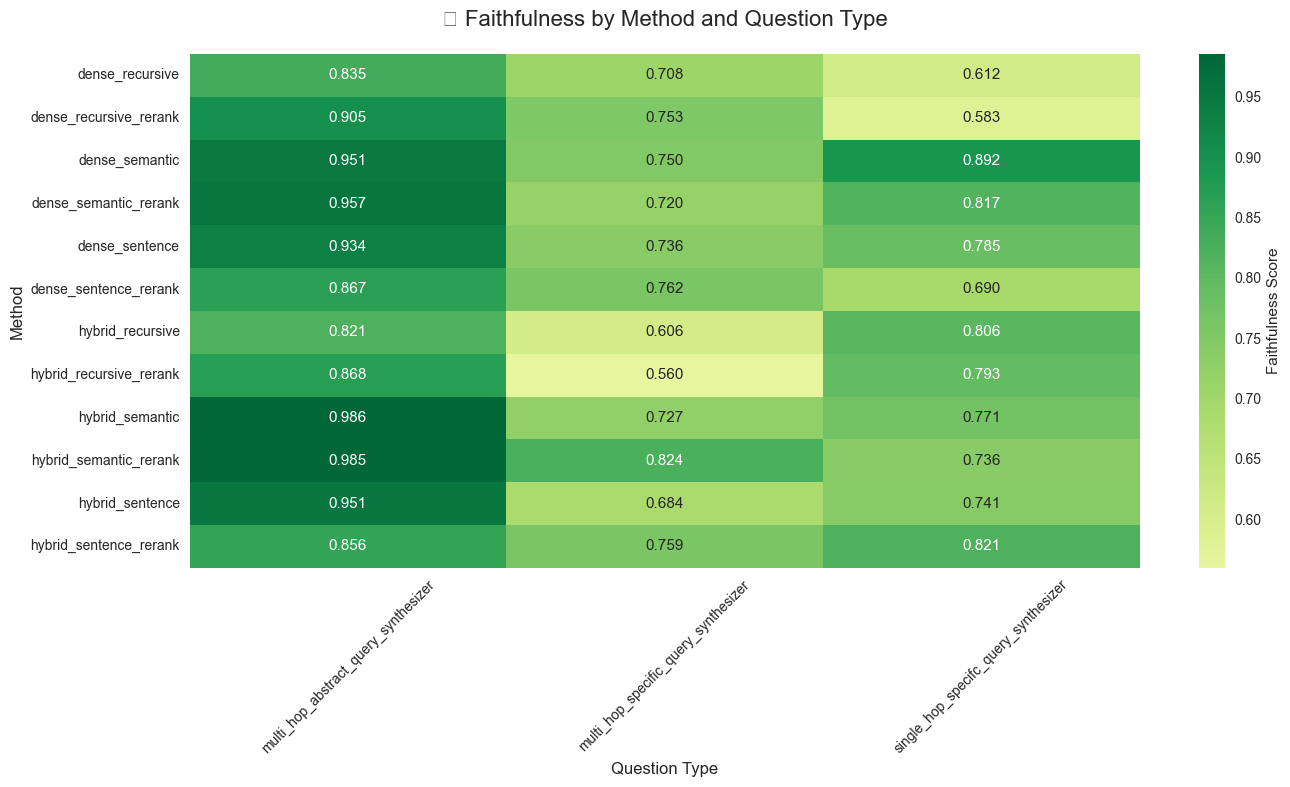


📊 QUESTION TYPE DIFFICULTY RANKING:
(Lower score = more difficult)
1. multi_hop_specific_query_synthesizer: 0.716
2. single_hop_specifc_query_synthesizer: 0.755
3. multi_hop_abstract_query_synthesizer: 0.909


In [8]:
# 📈 QUESTION TYPE HEATMAP VISUALIZATION
plt.figure(figsize=(14, 8))
sns.heatmap(faithfulness_by_type.T, annot=True, cmap='RdYlGn', center=0.5,
            fmt='.3f', cbar_kws={'label': 'Faithfulness Score'})
plt.title('🎯 Faithfulness by Method and Question Type', fontsize=16, pad=20)
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Method', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate question type difficulty
print("\n📊 QUESTION TYPE DIFFICULTY RANKING:")
difficulty = df.groupby('question_type')['faithfulness'].mean().sort_values()
print("(Lower score = more difficult)")
for i, (qtype, score) in enumerate(difficulty.items(), 1):
    print(f"{i}. {qtype}: {score:.3f}")

## ⚡ 3. PERFORMANCE vs EFFICIENCY ANALYSIS

⚡ RUNTIME PERFORMANCE (seconds per query)
                         mean   std  median   min   max
method                                                 
hybrid_recursive         2.52  0.60    2.56  1.10  3.31
hybrid_semantic          2.60  0.57    2.65  1.08  3.41
dense_recursive          2.66  0.59    2.75  1.01  3.47
hybrid_sentence          2.83  0.62    2.99  1.00  3.59
hybrid_recursive_rerank  3.31  0.56    3.39  1.91  4.38
dense_recursive_rerank   3.37  0.62    3.50  1.91  4.20
hybrid_sentence_rerank   3.54  0.58    3.59  2.08  4.43
hybrid_semantic_rerank   3.59  0.56    3.62  2.10  4.52
dense_semantic           3.70  1.22    3.31  1.29  7.21
dense_sentence           3.70  1.43    3.49  1.00  6.19
dense_semantic_rerank    4.14  1.01    4.01  2.00  7.02
dense_sentence_rerank    4.70  1.32    4.26  2.22  7.41

🏃‍♂️ SPEED RANKING (fastest to slowest):
1. hybrid_recursive: 2.5s
2. hybrid_semantic: 2.6s
3. dense_recursive: 2.7s
4. hybrid_sentence: 2.8s
5. hybrid_recursive_rerank: 3.3

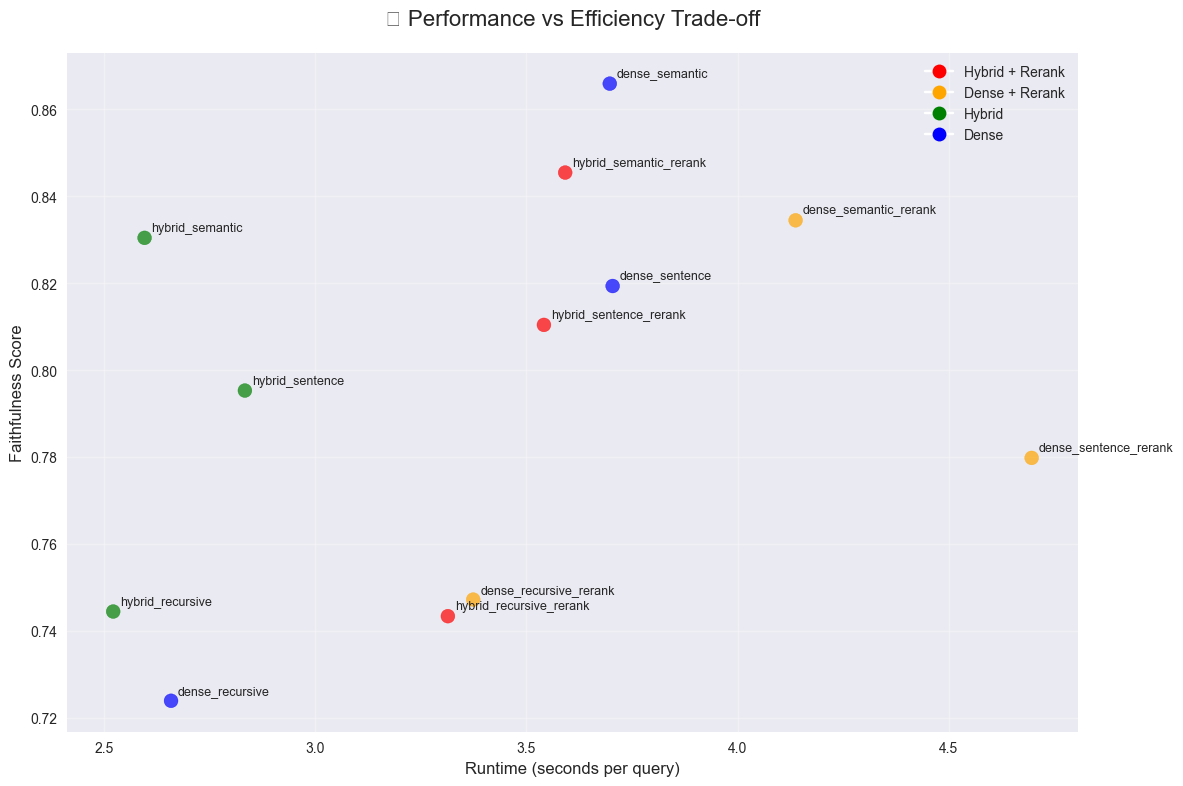

In [9]:
# ⚡ RUNTIME ANALYSIS
def runtime_analysis():
    """Analyze runtime performance across methods"""
    
    runtime_stats = df.groupby('method')['runtime_seconds'].agg([
        'mean', 'std', 'median', 'min', 'max'
    ]).round(2)
    
    runtime_stats = runtime_stats.sort_values('mean')
    
    print("⚡ RUNTIME PERFORMANCE (seconds per query)")
    print("=" * 60)
    print(runtime_stats)
    
    # Speed ranking
    print("\n🏃‍♂️ SPEED RANKING (fastest to slowest):")
    for i, (method, time) in enumerate(runtime_stats['mean'].items(), 1):
        print(f"{i}. {method}: {time:.1f}s")
    
    return runtime_stats

runtime_stats = runtime_analysis()

# Runtime vs Quality Scatter Plot
plt.figure(figsize=(12, 8))
method_stats = df.groupby('method').agg({
    'runtime_seconds': 'mean',
    'faithfulness': 'mean',
    'used_reranker': 'first',
    'retrieval_mode': 'first'
}).reset_index()

def get_color(row):
    if row['used_reranker'] and row['retrieval_mode'] == 'hybrid':
        return 'red'        # Hybrid + Rerank
    elif row['used_reranker'] and row['retrieval_mode'] == 'dense':
        return 'orange'     # Dense + Rerank
    elif row['retrieval_mode'] == 'hybrid':
        return 'green'      # Hybrid only
    else:
        return 'blue'       # Dense only

colors = [get_color(row) for _, row in method_stats.iterrows()]

plt.scatter(method_stats['runtime_seconds'], method_stats['faithfulness'], 
           c=colors, s=100, alpha=0.7)

# Add method labels
for _, row in method_stats.iterrows():
    plt.annotate(row['method'], 
                (row['runtime_seconds'], row['faithfulness']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Runtime (seconds per query)', fontsize=12)
plt.ylabel('Faithfulness Score', fontsize=12)
plt.title('⚡ Performance vs Efficiency Trade-off', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Hybrid + Rerank'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Dense + Rerank'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Hybrid'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Dense')
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

In [10]:
# NEUE ANALYSE: Reranker Impact by Retrieval Mode
def reranker_impact_by_mode():
    """Zeigt Reranker Impact getrennt für Dense und Hybrid"""
    
    # Dense Reranker Impact
    dense_no_rerank = df[(df['retrieval_mode'] == 'dense') & 
                        (df['has_reranker'] == False)]['faithfulness'].mean()
    dense_with_rerank = df[(df['retrieval_mode'] == 'dense') & 
                          (df['has_reranker'] == True)]['faithfulness'].mean()
    dense_improvement = ((dense_with_rerank - dense_no_rerank) / dense_no_rerank * 100)
    
    # Hybrid Reranker Impact  
    hybrid_no_rerank = df[(df['retrieval_mode'] == 'hybrid') & 
                         (df['has_reranker'] == False)]['faithfulness'].mean()
    hybrid_with_rerank = df[(df['retrieval_mode'] == 'hybrid') & 
                           (df['has_reranker'] == True)]['faithfulness'].mean()
    hybrid_improvement = ((hybrid_with_rerank - hybrid_no_rerank) / hybrid_no_rerank * 100)
    
    print("🎯 RERANKER IMPACT BY RETRIEVAL MODE:")
    print(f"Dense + Reranker: {dense_improvement:+.1f}%")
    print(f"Hybrid + Reranker: {hybrid_improvement:+.1f}%")
    
    return {'dense': dense_improvement, 'hybrid': hybrid_improvement}

## 🔬 4. ADVANCED STATISTICAL ANALYSIS

In [11]:
# 🔬 COMPONENT IMPACT ANALYSIS
def component_impact_analysis():
    """Analyze impact of different pipeline components using paired tests."""
    
    print("🔬 COMPONENT IMPACT ANALYSIS")
    print("=" * 50)
    
    # 1. Dense vs Hybrid Impact
    print("\n📊 RETRIEVAL MODE IMPACT (Dense vs Hybrid):")
    available_metrics = [m for m in METRICS[:4] if m in df.columns]
    retrieval_impact = df.groupby('retrieval_mode')[available_metrics].mean()
    print(retrieval_impact.round(3))
    
    # Paired Wilcoxon: pool all dense vs hybrid scores per question
    dense_faith = df[df['retrieval_mode'] == 'dense'].groupby('question')['faithfulness'].mean()
    hybrid_faith = df[df['retrieval_mode'] == 'hybrid'].groupby('question')['faithfulness'].mean()
    common_qs = dense_faith.index.intersection(hybrid_faith.index)
    if len(common_qs) > 0:
        diff = hybrid_faith[common_qs].values - dense_faith[common_qs].values
        if np.any(diff != 0):
            _, p_val = stats.wilcoxon(diff, zero_method='zsplit')
            print(f"Hybrid vs Dense faithfulness (paired Wilcoxon): p={p_val:.3f}")
        else:
            print("Hybrid vs Dense faithfulness: no difference")
    
    # 2. Chunking Strategy Impact
    print("\n🧩 CHUNKING STRATEGY IMPACT:")
    chunking_impact = df.groupby('chunking_strategy')[available_metrics].mean()
    print(chunking_impact.round(3))
    
    # 3. Reranker Impact
    print("\n🎯 RERANKER IMPACT:")
    rerank_impact = df.groupby('has_reranker')[available_metrics].mean()
    rerank_impact.index = ['Without Reranker', 'With Reranker']
    print(rerank_impact.round(3))
    
    # Paired Wilcoxon for reranker
    no_rerank_faith = df[df['has_reranker'] == False].groupby('question')['faithfulness'].mean()
    with_rerank_faith = df[df['has_reranker'] == True].groupby('question')['faithfulness'].mean()
    common_qs = no_rerank_faith.index.intersection(with_rerank_faith.index)
    if len(common_qs) > 0:
        diff = with_rerank_faith[common_qs].values - no_rerank_faith[common_qs].values
        improvement = (with_rerank_faith[common_qs].mean() - no_rerank_faith[common_qs].mean()) / no_rerank_faith[common_qs].mean() * 100
        if np.any(diff != 0):
            _, p_val = stats.wilcoxon(diff, zero_method='zsplit')
            print(f"Reranker improvement: {improvement:+.1f}% (paired Wilcoxon p={p_val:.3f})")
        else:
            print(f"Reranker improvement: {improvement:+.1f}% (no variance in differences)")
    
    # 4. Reranker impact BY chunking strategy (for thesis Table reranker-by-strategy)
    print("\n🎯 RERANKER IMPACT BY CHUNKING STRATEGY (Faithfulness):")
    print(f"{'Strategy':<25} {'without':>8} {'with':>8} {'Δ':>8}")
    for chunking in ['recursive', 'sentence_transformer', 'semantic']:
        without = df[(df['chunking_strategy'] == chunking) & (df['has_reranker'] == False)]['faithfulness'].mean()
        with_r = df[(df['chunking_strategy'] == chunking) & (df['has_reranker'] == True)]['faithfulness'].mean()
        delta_pct = (with_r - without) / without * 100 if without > 0 else 0
        print(f"{chunking:<25} {without:8.3f} {with_r:8.3f} {delta_pct:+7.1f}%")
    
    return retrieval_impact, chunking_impact, rerank_impact

retrieval_impact, chunking_impact, rerank_impact = component_impact_analysis()

🔬 COMPONENT IMPACT ANALYSIS

📊 RETRIEVAL MODE IMPACT (Dense vs Hybrid):
                context_precision  faithfulness  answer_relevancy  \
retrieval_mode                                                      
dense                       0.960         0.795             0.868   
hybrid                      0.969         0.795             0.876   

                context_recall  
retrieval_mode                  
dense                    0.822  
hybrid                   0.905  
Hybrid vs Dense faithfulness (paired Wilcoxon): p=nan

🧩 CHUNKING STRATEGY IMPACT:
                      context_precision  faithfulness  answer_relevancy  \
chunking_strategy                                                         
recursive                         0.964         0.740             0.855   
semantic                          0.967         0.844             0.890   
sentence_transformer              0.962         0.801             0.871   

                      context_recall  
chunking_strategy    

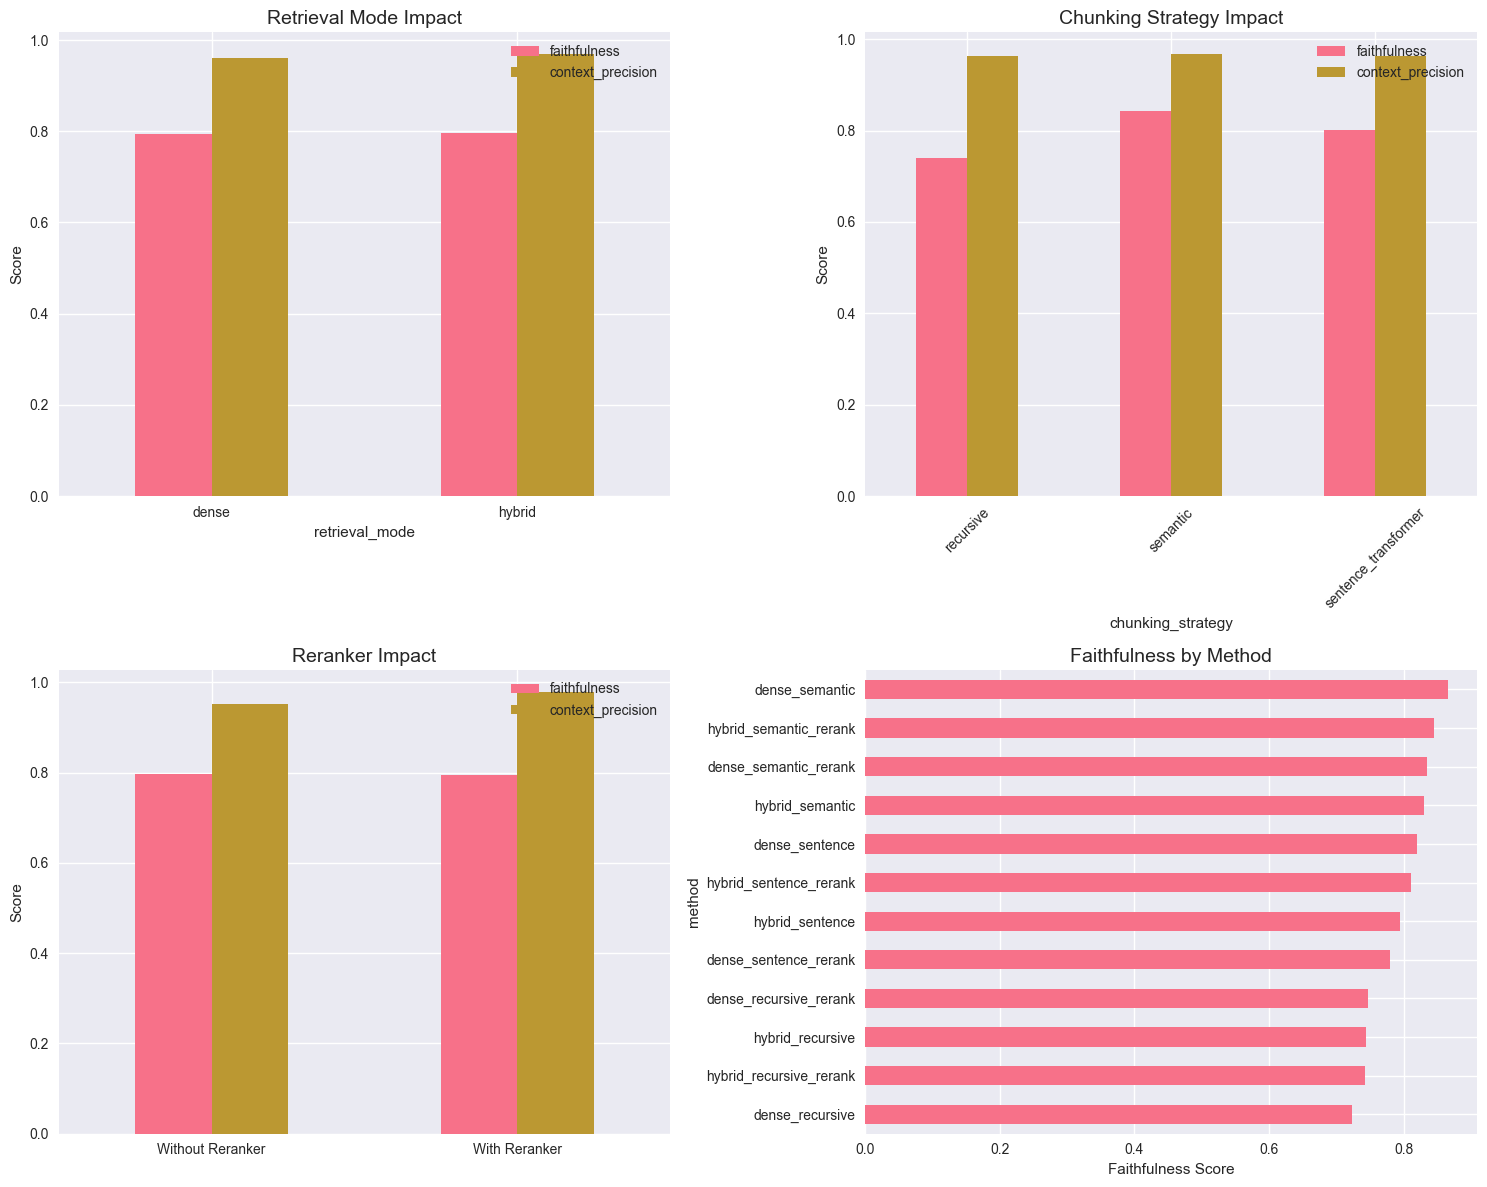

In [12]:
# 📊 COMPONENT IMPACT VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Retrieval Mode Comparison
retrieval_impact[['faithfulness', 'context_precision']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Retrieval Mode Impact', fontsize=14)
axes[0,0].set_ylabel('Score')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Chunking Strategy Comparison
chunking_impact[['faithfulness', 'context_precision']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Chunking Strategy Impact', fontsize=14)
axes[0,1].set_ylabel('Score')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Reranker Impact
rerank_impact[['faithfulness', 'context_precision']].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Reranker Impact', fontsize=14)
axes[1,0].set_ylabel('Score')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Method Ranking
method_faithfulness = df.groupby('method')['faithfulness'].mean().sort_values(ascending=True)
method_faithfulness.plot(kind='barh', ax=axes[1,1])
axes[1,1].set_title('Faithfulness by Method', fontsize=14)
axes[1,1].set_xlabel('Faithfulness Score')

plt.tight_layout()
plt.show()

In [13]:
# NEUE ZELLE: Top 5 Methods
def show_top_performers():
    """Zeigt die Top 5 Methoden"""
    top_5 = df.groupby('method')['faithfulness'].mean().nlargest(5)
    
    plt.figure(figsize=(10, 6))
    top_5.plot(kind='barh', color=['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen'])
    plt.title('🏆 Top 5 Methods by Faithfulness')
    plt.xlabel('Faithfulness Score')
    
    for i, (method, score) in enumerate(top_5.items()):
        plt.text(score, i, f' {score:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return top_5

## 🎯 5. FINAL RECOMMENDATIONS

In [14]:
# 🎯 GENERATE ACTIONABLE RECOMMENDATIONS
def generate_recommendations():
    """Generate data-driven recommendations"""
    
    print("🎯 ACTIONABLE RECOMMENDATIONS")
    print("=" * 50)
    
    # Best overall method
    best_method = df.groupby('method')['faithfulness'].mean().idxmax()
    best_score = df.groupby('method')['faithfulness'].mean().max()
    print(f"\n🏆 BEST OVERALL METHOD: {best_method} ({best_score:.3f} faithfulness)")
    
    # Best for speed
    fastest_method = df.groupby('method')['runtime_seconds'].mean().idxmin()
    fastest_time = df.groupby('method')['runtime_seconds'].mean().min()
    print(f"🏃‍♂️ FASTEST METHOD: {fastest_method} ({fastest_time:.1f}s per query)")
    
    # Best balance
    method_stats = df.groupby('method').agg({
        'faithfulness': 'mean',
        'runtime_seconds': 'mean'
    })
    
    # Normalize scores (higher is better for both)
    method_stats['faithfulness_norm'] = (method_stats['faithfulness'] - method_stats['faithfulness'].min()) / (method_stats['faithfulness'].max() - method_stats['faithfulness'].min())
    method_stats['speed_norm'] = (method_stats['runtime_seconds'].max() - method_stats['runtime_seconds']) / (method_stats['runtime_seconds'].max() - method_stats['runtime_seconds'].min())
    method_stats['balance_score'] = (method_stats['faithfulness_norm'] + method_stats['speed_norm']) / 2
    
    best_balance = method_stats['balance_score'].idxmax()
    print(f"⚖️ BEST BALANCE: {best_balance}")
    
    # Component recommendations
    print("\n📋 COMPONENT RECOMMENDATIONS:")
    
    # Retrieval mode
    dense_mean = df[df['retrieval_mode'] == 'dense']['faithfulness'].mean()
    hybrid_mean = df[df['retrieval_mode'] == 'hybrid']['faithfulness'].mean()
    better_retrieval = 'Hybrid' if hybrid_mean > dense_mean else 'Dense'
    improvement = abs(hybrid_mean - dense_mean) / min(hybrid_mean, dense_mean) * 100
    print(f"• Retrieval Mode: Use {better_retrieval} (+{improvement:.1f}% vs alternative)")
    
    # Chunking strategy
    best_chunking = df.groupby('chunking_strategy')['faithfulness'].mean().idxmax()
    print(f"• Chunking Strategy: Use {best_chunking}")
    
    # Reranker
    rerank_improvement = (df[df['has_reranker'] == True]['faithfulness'].mean() - 
                         df[df['has_reranker'] == False]['faithfulness'].mean()) / \
                         df[df['has_reranker'] == False]['faithfulness'].mean() * 100
    runtime_cost = (df[df['has_reranker'] == True]['runtime_seconds'].mean() - 
                   df[df['has_reranker'] == False]['runtime_seconds'].mean())
    
    if rerank_improvement > 5:  # Arbitrary threshold
        print(f"• Reranker: RECOMMENDED (+{rerank_improvement:.1f}% quality, +{runtime_cost:.1f}s runtime)")
    else:
        print(f"• Reranker: OPTIONAL (+{rerank_improvement:.1f}% quality, +{runtime_cost:.1f}s runtime)")
    
    print("\n💡 USE CASE SPECIFIC RECOMMENDATIONS:")
    print("• For Production (Speed Priority): Use fastest method with acceptable quality")
    print("• For Research (Quality Priority): Use best performing method regardless of speed")
    print("• For Balanced Use: Use method with best quality/speed trade-off")
    
    return method_stats

final_stats = generate_recommendations()

🎯 ACTIONABLE RECOMMENDATIONS

🏆 BEST OVERALL METHOD: dense_semantic (0.866 faithfulness)
🏃‍♂️ FASTEST METHOD: hybrid_recursive (2.5s per query)
⚖️ BEST BALANCE: hybrid_semantic

📋 COMPONENT RECOMMENDATIONS:
• Retrieval Mode: Use Hybrid (+0.0% vs alternative)
• Chunking Strategy: Use semantic
• Reranker: OPTIONAL (+-0.3% quality, +0.8s runtime)

💡 USE CASE SPECIFIC RECOMMENDATIONS:
• For Production (Speed Priority): Use fastest method with acceptable quality
• For Research (Quality Priority): Use best performing method regardless of speed
• For Balanced Use: Use method with best quality/speed trade-off


In [15]:
# 📊 COMPREHENSIVE RESULTS EXPORT
def export_results():
    """Export all analysis results for thesis/reporting"""
    
    print("📁 EXPORTING ANALYSIS RESULTS...")
    
    # 1. Summary Statistics
    summary.to_csv('./analysis_results/method_summary.csv', index=False)
    print("✅ Method summary exported")
    
    # 2. Delta Analysis
    delta_analysis.to_csv('./analysis_results/delta_to_baseline.csv', index=False)
    print("✅ Delta analysis exported")
    
    # 3. Component Impact
    component_results = {
        'retrieval_mode': retrieval_impact,
        'chunking_strategy': chunking_impact,
        'reranker_impact': rerank_impact
    }
    
    with pd.ExcelWriter('./analysis_results/component_analysis.xlsx') as writer:
        for sheet_name, data in component_results.items():
            data.to_excel(writer, sheet_name=sheet_name)
    print("✅ Component analysis exported")
    
    # 4. Question Type Analysis
    faithfulness_by_type.to_csv('./analysis_results/question_type_analysis.csv')
    print("✅ Question type analysis exported")
    
    # 5. Final Rankings
    rankings = {
        'method': df.groupby('method')['faithfulness'].mean().sort_values(ascending=False),
        'runtime': df.groupby('method')['runtime_seconds'].mean().sort_values(),
        'balance': final_stats['balance_score'].sort_values(ascending=False)
    }
    
    rankings_df = pd.DataFrame(rankings)
    rankings_df.to_csv('./analysis_results/final_rankings.csv')
    print("✅ Final rankings exported")
    
    print("\n🎉 ALL RESULTS EXPORTED TO ./analysis_results/")

import os
os.makedirs('./analysis_results', exist_ok=True)
export_results()

📁 EXPORTING ANALYSIS RESULTS...
✅ Method summary exported
✅ Delta analysis exported
✅ Component analysis exported
✅ Question type analysis exported
✅ Final rankings exported

🎉 ALL RESULTS EXPORTED TO ./analysis_results/


## 🔥 6. MEGA VISUALIZATION DASHBOARD

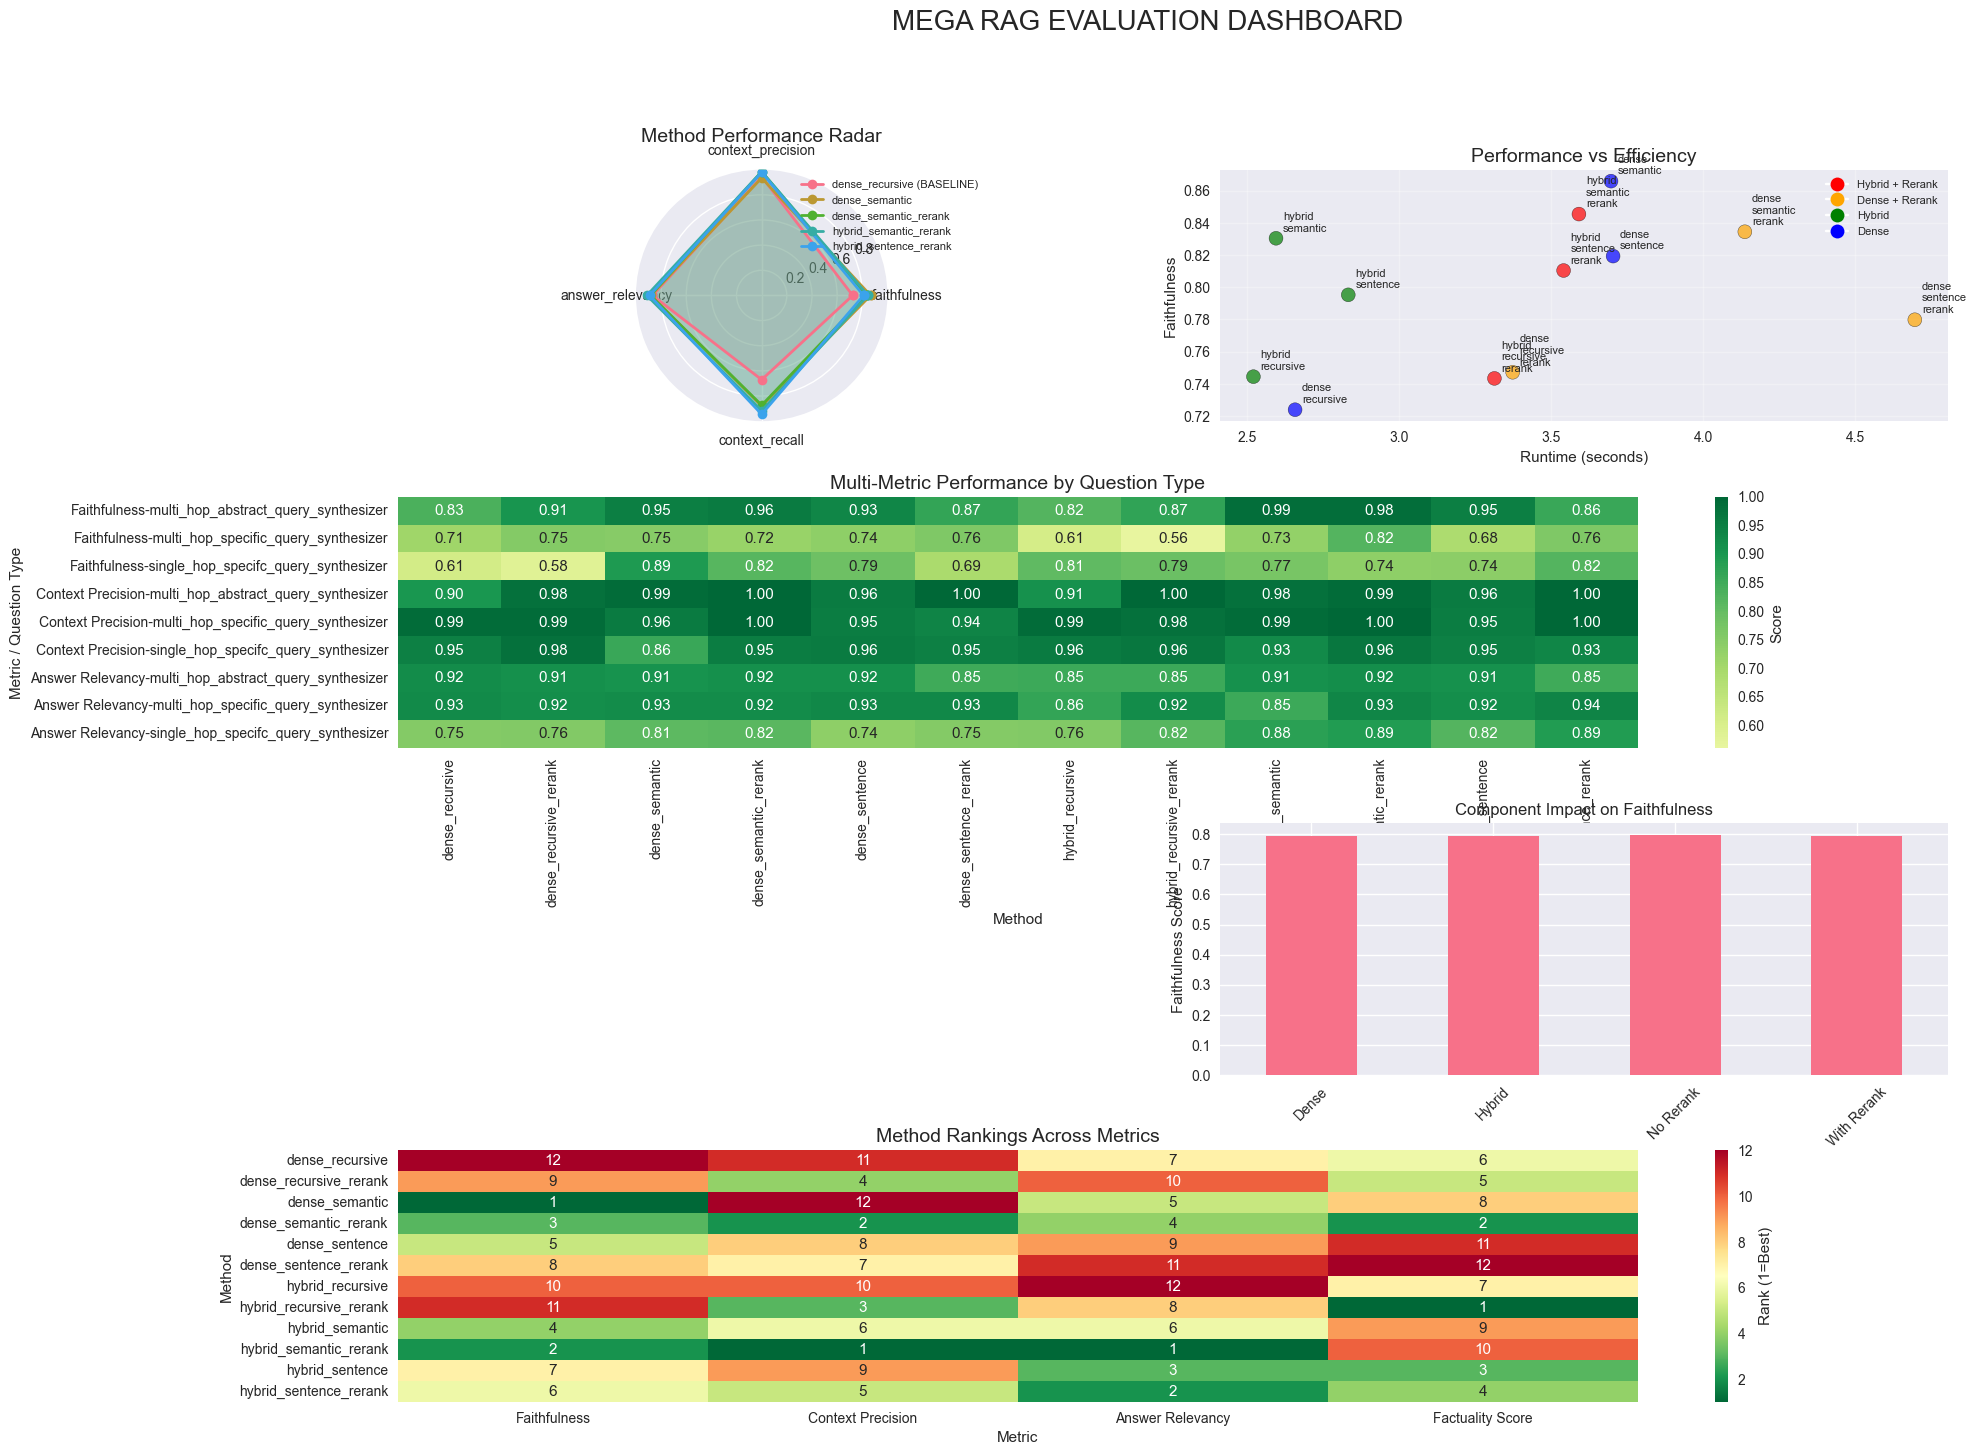

In [16]:
# 🔥 ULTIMATE DASHBOARD VISUALIZATION
def create_mega_dashboard():
    """Create the ultimate analysis dashboard"""
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # 1. Method Performance Radar Chart
    ax1 = fig.add_subplot(gs[0, :2], projection='polar')
    
    methods_for_radar = [
        EFFECTIVE_BASELINE,             # Baseline (dense_recursive)
        'dense_semantic',               # Best Faithfulness
        'dense_semantic_rerank',        # Dense + Reranker  
        'hybrid_semantic_rerank',       # Hybrid + Reranker
        'hybrid_sentence_rerank',       # For comparison
    ]
    metrics_for_radar = ['faithfulness', 'context_precision', 'answer_relevancy', 'context_recall']
    
    angles = np.linspace(0, 2 * np.pi, len(metrics_for_radar), endpoint=False).tolist()
    angles += angles[:1]
    
    for method in methods_for_radar:
        if method not in df['method'].unique():
            continue
        values = [df[df['method'] == method][m].mean() for m in metrics_for_radar]
        values += values[:1]
        label = f"{method} (BASELINE)" if method == EFFECTIVE_BASELINE else method
        ax1.plot(angles, values, 'o-', linewidth=2, label=label)
        ax1.fill(angles, values, alpha=0.15)
    
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(metrics_for_radar)
    ax1.set_title('Method Performance Radar', size=14, y=1.08)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), fontsize=8)
    
    # 2. Performance vs Runtime Scatter
    ax2 = fig.add_subplot(gs[0, 2:])
    
    method_stats = df.groupby('method').agg({
        'runtime_seconds': 'mean',
        'faithfulness': 'mean',
        'has_reranker': 'first',
        'retrieval_mode': 'first'
    }).reset_index()
    
    colors = []
    for _, row in method_stats.iterrows():
        if row['has_reranker'] and row['retrieval_mode'] == 'hybrid':
            colors.append('red')
        elif row['has_reranker'] and row['retrieval_mode'] == 'dense':
            colors.append('orange')
        elif row['retrieval_mode'] == 'hybrid':
            colors.append('green')
        else:
            colors.append('blue')
    
    scatter = ax2.scatter(method_stats['runtime_seconds'], method_stats['faithfulness'], 
                         c=colors, s=100, alpha=0.7, edgecolors='black')
    
    for _, row in method_stats.iterrows():
        ax2.annotate(row['method'].replace('_', '\n'), 
                    (row['runtime_seconds'], row['faithfulness']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Runtime (seconds)')
    ax2.set_ylabel('Faithfulness')
    ax2.set_title('Performance vs Efficiency', size=14)
    ax2.grid(True, alpha=0.3)
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Hybrid + Rerank'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Dense + Rerank'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Hybrid'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Dense')
    ]
    ax2.legend(handles=legend_elements, fontsize=8)
    
    # 3. Question Type Heatmap
    ax3 = fig.add_subplot(gs[1, :])
    
    heatmap_data = []
    for metric in ['faithfulness', 'context_precision', 'answer_relevancy']:
        pivot = df.pivot_table(values=metric, index='question_type', columns='method', aggfunc='mean')
        heatmap_data.append(pivot)
    
    combined_heatmap = pd.concat(heatmap_data, keys=['Faithfulness', 'Context Precision', 'Answer Relevancy'])
    
    sns.heatmap(combined_heatmap, annot=True, cmap='RdYlGn', center=0.5, ax=ax3,
                fmt='.2f', cbar_kws={'label': 'Score'})
    ax3.set_title('Multi-Metric Performance by Question Type', size=14)
    ax3.set_xlabel('Method')
    ax3.set_ylabel('Metric / Question Type')
    
    # 5. Component Impact
    ax5 = fig.add_subplot(gs[2, 2:])
    
    component_data = pd.DataFrame({
        'Dense': [df[df['retrieval_mode'] == 'dense']['faithfulness'].mean()],
        'Hybrid': [df[df['retrieval_mode'] == 'hybrid']['faithfulness'].mean()],
        'No Rerank': [df[df['has_reranker'] == False]['faithfulness'].mean()],
        'With Rerank': [df[df['has_reranker'] == True]['faithfulness'].mean()]
    })
    
    component_data.T.plot(kind='bar', ax=ax5, legend=False)
    ax5.set_title('Component Impact on Faithfulness')
    ax5.set_ylabel('Faithfulness Score')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Method Rankings
    ax6 = fig.add_subplot(gs[3, :])
    
    ranking_metrics = ['faithfulness', 'context_precision', 'answer_relevancy']
    if 'factuality_score' in df.columns:
        ranking_metrics.append('factuality_score')
    
    ranking_data = []
    ranking_labels = []
    for metric in ranking_metrics:
        if metric in df.columns:
            method_scores = df.groupby('method')[metric].mean().rank(ascending=False)
            ranking_data.append(method_scores)
            ranking_labels.append(metric.replace('_', ' ').title())
    
    ranking_df = pd.DataFrame(ranking_data, index=ranking_labels).T
    
    sns.heatmap(ranking_df, annot=True, cmap='RdYlGn_r', ax=ax6, fmt='.0f',
                cbar_kws={'label': 'Rank (1=Best)'})
    ax6.set_title('Method Rankings Across Metrics', size=14)
    ax6.set_xlabel('Metric')
    ax6.set_ylabel('Method')
    
    plt.suptitle('MEGA RAG EVALUATION DASHBOARD', fontsize=20, y=0.98)
    plt.tight_layout()
    plt.show()

create_mega_dashboard()

## 📊 7. THESIS-READY SUMMARY TABLE

In [17]:
# 📊 PUBLICATION-READY RESULTS TABLE
def create_thesis_table():
    """Create publication-ready results table for thesis"""
    
    thesis_data = []
    
    for method in sorted(df['method'].unique()):
        method_data = df[df['method'] == method]
        
        row = {
            'Method': method.replace('_', ' ').title(),
            'Faithfulness': f"{method_data['faithfulness'].mean():.3f} ± {method_data['faithfulness'].std():.3f}",
            'Context Precision': f"{method_data['context_precision'].mean():.3f} ± {method_data['context_precision'].std():.3f}",
            'Answer Relevancy': f"{method_data['answer_relevancy'].mean():.3f} ± {method_data['answer_relevancy'].std():.3f}",
            'Context Recall': f"{method_data['context_recall'].mean():.3f} ± {method_data['context_recall'].std():.3f}",
            'Runtime (s)': f"{method_data['runtime_seconds'].mean():.1f} ± {method_data['runtime_seconds'].std():.1f}",
            'Factuality': f"{method_data['factuality_score'].mean():.3f} ± {method_data['factuality_score'].std():.3f}"
        }
        
        thesis_data.append(row)
    
    thesis_df = pd.DataFrame(thesis_data)
    
    print("📊 THESIS-READY RESULTS TABLE")
    print("=" * 120)
    print(thesis_df.to_string(index=False))
    
    # Export for LaTeX
    latex_table = thesis_df.to_latex(index=False, escape=False)
    with open('./analysis_results/thesis_table.tex', 'w') as f:
        f.write(latex_table)
    
    print("\n✅ LaTeX table exported to ./analysis_results/thesis_table.tex")
    
    return thesis_df

thesis_table = create_thesis_table()

📊 THESIS-READY RESULTS TABLE
                 Method  Faithfulness Context Precision Answer Relevancy Context Recall Runtime (s)    Factuality
        Dense Recursive 0.724 ± 0.347     0.944 ± 0.140    0.869 ± 0.246  0.670 ± 0.465   2.7 ± 0.6 0.509 ± 0.068
 Dense Recursive Rerank 0.747 ± 0.372     0.980 ± 0.055    0.862 ± 0.245  0.860 ± 0.322   3.4 ± 0.6 0.511 ± 0.076
         Dense Semantic 0.866 ± 0.185     0.935 ± 0.186    0.882 ± 0.203  0.880 ± 0.272   3.7 ± 1.2 0.507 ± 0.064
  Dense Semantic Rerank 0.834 ± 0.263     0.984 ± 0.081    0.884 ± 0.204  0.873 ± 0.335   4.1 ± 1.0 0.515 ± 0.067
         Dense Sentence 0.819 ± 0.282     0.956 ± 0.121    0.865 ± 0.249  0.736 ± 0.452   3.7 ± 1.4 0.494 ± 0.087
  Dense Sentence Rerank 0.780 ± 0.302     0.962 ± 0.125    0.844 ± 0.279  0.917 ± 0.289   4.7 ± 1.3 0.494 ± 0.086
       Hybrid Recursive 0.744 ± 0.343     0.952 ± 0.138    0.824 ± 0.309  0.770 ± 0.393   2.5 ± 0.6 0.507 ± 0.066
Hybrid Recursive Rerank 0.743 ± 0.306     0.980 ± 0.084    

## 🎯 8. KEY INSIGHTS & CONCLUSIONS

In [18]:
# 🎯 GENERATE KEY INSIGHTS
def generate_key_insights():
    """Generate key insights for thesis conclusions"""
    
    print("🎯 KEY INSIGHTS & CONCLUSIONS")
    print("=" * 60)
    
    # 1. Best performing method
    best_method = df.groupby('method')['faithfulness'].mean().idxmax()
    best_score = df.groupby('method')['faithfulness'].mean().max()
    worst_score = df.groupby('method')['faithfulness'].mean().min()
    improvement = (best_score - worst_score) / worst_score * 100
    
    print(f"\n🏆 PERFORMANCE INSIGHTS:")
    print(f"• Best method: {best_method} (Faithfulness: {best_score:.3f})")
    print(f"• Performance gap: {improvement:.1f}% between best and worst methods")
    
    # 2. Component impact insights
    hybrid_vs_dense = (df[df['retrieval_mode'] == 'hybrid']['faithfulness'].mean() - 
                       df[df['retrieval_mode'] == 'dense']['faithfulness'].mean()) / \
                       df[df['retrieval_mode'] == 'dense']['faithfulness'].mean() * 100
    
    rerank_impact = (df[df['has_reranker'] == True]['faithfulness'].mean() - 
                    df[df['has_reranker'] == False]['faithfulness'].mean()) / \
                    df[df['has_reranker'] == False]['faithfulness'].mean() * 100
    
    print(f"\n🔧 COMPONENT INSIGHTS:")
    print(f"• Hybrid retrieval impact: {hybrid_vs_dense:+.1f}% vs dense retrieval")
    print(f"• Reranker impact: {rerank_impact:+.1f}% improvement in faithfulness")
    
    # 3. Question type insights
    easiest_qtype = df.groupby('question_type')['faithfulness'].mean().idxmax()
    hardest_qtype = df.groupby('question_type')['faithfulness'].mean().idxmin()
    
    print(f"\n🎯 QUESTION TYPE INSIGHTS:")
    print(f"• Easiest question type: {easiest_qtype}")
    print(f"• Most challenging: {hardest_qtype}")
    
    # 4. Efficiency insights
    fastest_method = df.groupby('method')['runtime_seconds'].mean().idxmin()
    slowest_method = df.groupby('method')['runtime_seconds'].mean().idxmax()
    speed_ratio = df.groupby('method')['runtime_seconds'].mean().max() / \
                  df.groupby('method')['runtime_seconds'].mean().min()
    
    print(f"\n⚡ EFFICIENCY INSIGHTS:")
    print(f"• Fastest method: {fastest_method}")
    print(f"• Slowest method: {slowest_method}")
    print(f"• Speed difference: {speed_ratio:.1f}x between fastest and slowest")
    
    # 5. Practical recommendations
    print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
    
    # Find best balance method
    balance_scores = []
    for method in df['method'].unique():
        method_data = df[df['method'] == method]
        faith_norm = (method_data['faithfulness'].mean() - df['faithfulness'].min()) / \
                     (df['faithfulness'].max() - df['faithfulness'].min())
        speed_norm = (df['runtime_seconds'].max() - method_data['runtime_seconds'].mean()) / \
                     (df['runtime_seconds'].max() - df['runtime_seconds'].min())
        balance = (faith_norm + speed_norm) / 2
        balance_scores.append((method, balance))
    
    best_balance_method = max(balance_scores, key=lambda x: x[1])[0]
    
    print(f"• For production systems: {best_balance_method} (best quality/speed trade-off)")
    print(f"• For research applications: {best_method} (highest quality)")
    print(f"• For resource-constrained environments: {fastest_method} (fastest)")
    
    # 6. Statistical significance summary
    print(f"\n📊 STATISTICAL SIGNIFICANCE:")
    significant_improvements = 0
    for method in df['method'].unique():
        if method == BASELINE_METHOD:
            continue
        method_data = df[df['method'] == method]['faithfulness'].dropna()
        baseline_data = df[df['method'] == BASELINE_METHOD]['faithfulness'].dropna()
        if len(method_data) > 0 and len(baseline_data) > 0:
            _, p_val = stats.ttest_ind(method_data, baseline_data)
            if p_val < 0.05:
                significant_improvements += 1
    
    print(f"• {significant_improvements} methods show statistically significant differences vs baseline (p<0.05)")
    
    return {
        'best_method': best_method,
        'best_balance': best_balance_method,
        'fastest_method': fastest_method,
        'performance_gap': improvement,
        'hybrid_improvement': hybrid_vs_dense,
        'reranker_improvement': rerank_impact
    }

insights = generate_key_insights()

print("\n" + "="*60)
print("🎉 ANALYSIS COMPLETE! Check ./analysis_results/ for all exports.")
print("📊 Ready for thesis integration and publication!")
# 🔥 MEGA RAG EVALUATION ANALYSIS 🔥

#Comprehensive analysis of RAG pipeline performance across different chunking strategies, retrieval modes, and reranking approaches.**

🎯 KEY INSIGHTS & CONCLUSIONS

🏆 PERFORMANCE INSIGHTS:
• Best method: dense_semantic (Faithfulness: 0.866)
• Performance gap: 19.6% between best and worst methods

🔧 COMPONENT INSIGHTS:
• Hybrid retrieval impact: +0.0% vs dense retrieval
• Reranker impact: -0.3% improvement in faithfulness

🎯 QUESTION TYPE INSIGHTS:
• Easiest question type: multi_hop_abstract_query_synthesizer
• Most challenging: multi_hop_specific_query_synthesizer

⚡ EFFICIENCY INSIGHTS:
• Fastest method: hybrid_recursive
• Slowest method: dense_sentence_rerank
• Speed difference: 1.9x between fastest and slowest

💡 PRACTICAL RECOMMENDATIONS:
• For production systems: hybrid_semantic (best quality/speed trade-off)
• For research applications: dense_semantic (highest quality)
• For resource-constrained environments: hybrid_recursive (fastest)

📊 STATISTICAL SIGNIFICANCE:
• 0 methods show statistically significant differences vs baseline (p<0.05)

🎉 ANALYSIS COMPLETE! Check ./analysis_results/ for all exports.
📊 Ready f

## 9. THESIS REPRODUCIBILITY — Statistical Tables

Reproduces **all** statistical tables from the thesis (Wilcoxon signed-rank, Holm correction, rank-biserial correlation, question-type breakdown, Pearson correlation matrix) using only the `final_run_42Q` CSV data.

In [19]:
from scipy.stats import wilcoxon, pearsonr, rankdata, spearmanr
from pathlib import Path

# ============================================================
# TABLE A: Wilcoxon signed-rank test vs dense_semantic (Holm)
#   → reproduces thesis Table "tab:significance-faith-densesem"
#   → uses EXACT method from Appendix (app:sign):
#     zero_method='zsplit', correction=False, merge on 'question'
# ============================================================
SIGNIFICANCE_BASELINE = 'dense_semantic'
data_dir = Path(f'./results/{CORPUS_NAME}/final_run_42Q')

def load_pipeline(m):
    d = pd.read_csv(data_dir / f'{m}_final_results.csv')
    return d[['question', 'faithfulness']].rename(columns={'faithfulness': m})

base = load_pipeline(SIGNIFICANCE_BASELINE).rename(columns={SIGNIFICANCE_BASELINE: 'base'})
pipelines = [f.stem.replace('_final_results', '')
             for f in sorted(data_dir.glob('*_final_results.csv'))
             if f.stem.replace('_final_results', '') != SIGNIFICANCE_BASELINE]

rows, raw_ps = [], []
for m in pipelines:
    dfm = load_pipeline(m)
    merged = base.merge(dfm, on='question', how='inner').dropna()
    diff = merged[m].to_numpy() - merged['base'].to_numpy()
    n = len(diff)
    if np.any(diff != 0):
        wstat, p = wilcoxon(diff, zero_method='zsplit', correction=False,
                            alternative='two-sided', mode='auto')
    else:
        wstat, p = 0.0, 1.0
    # rank-biserial correlation (same formula as appendix)
    nz = diff[diff != 0]
    if len(nz) > 0:
        ranks = rankdata(np.abs(nz))
        Wpos = np.sum(ranks[nz > 0]); Wneg = np.sum(ranks[nz < 0])
        r_rb = (Wpos - Wneg) / (len(nz) * (len(nz) + 1) / 2.0)
    else:
        r_rb = 0.0
    rows.append(dict(method=m, n=n, delta_mean=np.mean(diff),
                     delta_pct=np.mean(diff) / merged['base'].mean() * 100,
                     p_value=p, r_rb=r_rb))
    raw_ps.append(p)

out = pd.DataFrame(rows).sort_values('delta_mean', ascending=False).reset_index(drop=True)

# Holm adjustment (same manual formula as appendix)
mtests = len(out)
order = np.argsort(out['p_value'].values)
p_adj = np.empty(mtests)
for rank, idx in enumerate(order, start=1):
    p_adj[idx] = min(out.loc[idx, 'p_value'] * (mtests - rank + 1), 1.0)
out['p_holm'] = p_adj

def stars(p): return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''

print("=" * 90)
print("TABLE A: Faithfulness — paired Wilcoxon vs dense_semantic (Holm-adjusted)")
print("  Method: Appendix code (zero_method='zsplit', correction=False, merge on question)")
print("=" * 90)
for _, r in out.sort_values('delta_mean').iterrows():
    print(f"{r['method']:<30} N={r['n']}  ΔF={r['delta_mean']:+.3f}  "
          f"{r['delta_pct']:+5.1f}%  p(Holm)={r['p_holm']:.3f} "
          f"{stars(r['p_holm']):<3} r_rb={r['r_rb']:+.3f}")

# ============================================================
# TABLE B: dense_semantic_rerank by question type
#   → reproduces thesis Table "tab:semantic-question"
# ============================================================
QUESTION_PIPELINE = 'dense_semantic_rerank'
qt_metrics = ['context_precision', 'context_recall', 'faithfulness',
              'answer_relevancy', 'answer_correctness', 'answer_similarity']
qt_labels = {'single_hop_specifc_query_synthesizer': 'Single-hop Specific',
             'multi_hop_specific_query_synthesizer': 'Multi-hop Specific',
             'multi_hop_abstract_query_synthesizer': 'Multi-hop Abstract'}

sub = df[df['method'] == QUESTION_PIPELINE]
print("\n" + "=" * 90)
print(f"TABLE B: {QUESTION_PIPELINE} by question type (means)")
print("=" * 90)
print(f"{'Type':<22} {'CP':>6} {'CR':>6} {'F':>6} {'AR':>6} {'AC':>6} {'AS':>6}")
for qt_raw, qt_label in qt_labels.items():
    qs = sub[sub['question_type'] == qt_raw]
    vals = []
    for m in qt_metrics:
        if m in qs.columns:
            vals.append(qs[m].mean())
        else:
            vals.append(float('nan'))
    print(f"{qt_label:<22} " + " ".join(f"{v:6.3f}" for v in vals))

# ============================================================
# TABLE C: Pearson correlation matrix (dense_semantic_rerank)
#   → reproduces thesis Table "tab:metric-correlation"
# ============================================================
corr_metrics = ['faithfulness', 'answer_relevancy', 'answer_similarity',
                'context_precision', 'context_recall', 'answer_correctness']
corr_labels = ['F', 'AR', 'AS', 'CP', 'CR', 'AC']

# Filter to only metrics that exist in the data
available_corr = [(m, l) for m, l in zip(corr_metrics, corr_labels) 
                  if m in df.columns]
corr_metrics_avail = [m for m, _ in available_corr]
corr_labels_avail = [l for _, l in available_corr]

corr_sub = df[df['method'] == QUESTION_PIPELINE][corr_metrics_avail]
corr_matrix = corr_sub.corr(method='pearson')

print("\n" + "=" * 90)
print(f"TABLE C: Pearson correlations ({QUESTION_PIPELINE}, n={len(corr_sub)})")
print("=" * 90)
header = f"{'':>25}" + "".join(f"{l:>7}" for l in corr_labels_avail)
print(header)
for i, (m, l) in enumerate(zip(corr_metrics_avail, corr_labels_avail)):
    vals = "".join(f"{corr_matrix.iloc[i, j]:7.2f}" if j <= i else "       "
                   for j in range(len(corr_metrics_avail)))
    print(f"{l:<25}{vals}")

# Key p-values for inline claims
for (m1, l1), (m2, l2) in [
    (('faithfulness', 'F'), ('answer_relevancy', 'AR')),
    (('faithfulness', 'F'), ('context_precision', 'CP')),
]:
    if m1 in corr_sub.columns and m2 in corr_sub.columns:
        r, p = pearsonr(corr_sub[m1], corr_sub[m2])
        print(f"\n  {l1} vs {l2}: r={r:.2f}, p={p:.2f}")

# ============================================================
# TABLE D: Factuality Score vs Faithfulness correlation
#   → reproduces thesis Table "tab:factual-faithfulness-corr"
# ============================================================
print("\n" + "=" * 90)
print("TABLE D: Correlation factuality_score vs faithfulness (top 3 pipelines)")
print("=" * 90)
top3 = ['dense_semantic', 'hybrid_semantic_rerank', 'hybrid_sentence_rerank']
print(f"{'Pipeline':<30} {'N':>4} {'Pearson r (p)':>16} {'Spearman ρ (p)':>16} {'Slope':>8} {'R²':>6}")
for pipe in top3:
    psub = df[df['method'] == pipe][['factuality_score', 'faithfulness']].dropna()
    if len(psub) < 5:
        continue
    r_p, p_p = pearsonr(psub['factuality_score'], psub['faithfulness'])
    r_s, p_s = spearmanr(psub['factuality_score'], psub['faithfulness'])
    slope = np.polyfit(psub['factuality_score'], psub['faithfulness'], 1)[0]
    r2 = r_p ** 2
    print(f"{pipe:<30} {len(psub):>4} {r_p:+.3f} ({p_p:.3f})   {r_s:+.3f} ({p_s:.3f})   {slope:+.3f}  {r2:.3f}")

print("\n✅ All thesis statistical tables reproduced using Appendix code method.")

TABLE A: Faithfulness — paired Wilcoxon vs dense_semantic (Holm-adjusted)
  Method: Appendix code (zero_method='zsplit', correction=False, merge on question)
hybrid_recursive_rerank        N=39  ΔF=-0.140  -16.2%  p(Holm)=0.281     r_rb=-0.569
dense_recursive                N=39  ΔF=-0.122  -14.0%  p(Holm)=0.911     r_rb=-0.479
dense_recursive_rerank         N=39  ΔF=-0.113  -12.7%  p(Holm)=1.000     r_rb=-0.370
hybrid_recursive               N=38  ΔF=-0.090  -10.4%  p(Holm)=1.000     r_rb=-0.450
dense_sentence_rerank          N=38  ΔF=-0.075   -8.6%  p(Holm)=1.000     r_rb=-0.231
dense_sentence                 N=36  ΔF=-0.026   -2.9%  p(Holm)=1.000     r_rb=-0.117
hybrid_sentence                N=34  ΔF=-0.022   -2.6%  p(Holm)=1.000     r_rb=-0.105
hybrid_sentence_rerank         N=38  ΔF=-0.020   -2.3%  p(Holm)=1.000     r_rb=+0.017
dense_semantic_rerank          N=41  ΔF=-0.019   -2.2%  p(Holm)=1.000     r_rb=-0.089
hybrid_semantic                N=40  ΔF=-0.018   -2.1%  p(Holm)=0.95

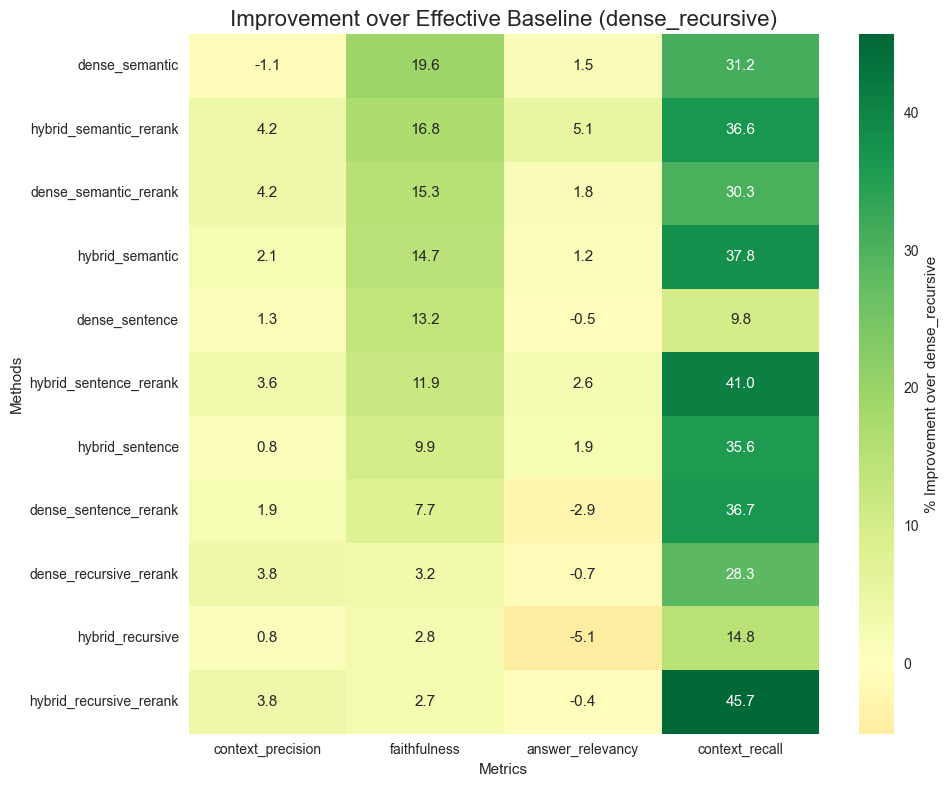


KEY INSIGHT: Best improvement over dense_recursive:
Faithfulness: 19.6% (dense_semantic)


In [20]:
# IMPROVEMENT OVER EFFECTIVE BASELINE HEATMAP
baseline_means = df[df['method'] == EFFECTIVE_BASELINE][METRICS[:4]].mean()

improvements = {}
for method in df['method'].unique():
    if method == EFFECTIVE_BASELINE:
        continue
    method_means = df[df['method'] == method][METRICS[:4]].mean()
    improvements[method] = ((method_means - baseline_means) / baseline_means * 100)

improvement_df = pd.DataFrame(improvements).T
improvement_df = improvement_df.sort_values('faithfulness', ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(improvement_df, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            cbar_kws={'label': f'% Improvement over {EFFECTIVE_BASELINE}'})
plt.title(f'Improvement over Effective Baseline ({EFFECTIVE_BASELINE})', fontsize=16)
plt.xlabel('Metrics')
plt.ylabel('Methods')
plt.tight_layout()
plt.show()

print(f"\nKEY INSIGHT: Best improvement over {EFFECTIVE_BASELINE}:")
print(f"Faithfulness: {improvement_df['faithfulness'].max():.1f}% ({improvement_df['faithfulness'].idxmax()})")

In [21]:
# Für die große Heatmap: Alle 12 Pipelines als Matrix
def create_component_heatmap():
    """Zeigt alle 12 Pipelines in organisierter 3x4 Matrix (Chunking x Retrieval+Rerank)"""
    
    # Build the matrix from actual method names in the data
    chunkings = ['recursive', 'sentence', 'semantic']
    modes = [
        ('dense', False, 'Dense'),
        ('dense', True, 'Dense+Rerank'),
        ('hybrid', False, 'Hybrid'),
        ('hybrid', True, 'Hybrid+Rerank'),
    ]
    
    matrix_data = {}
    for chunking in chunkings:
        for ret_mode, has_rerank, label in modes:
            # Find matching method
            mask = ((df['chunking_strategy'] == ('sentence_transformer' if chunking == 'sentence' else chunking)) & 
                    (df['retrieval_mode'] == ret_mode) & 
                    (df['has_reranker'] == has_rerank))
            subset = df[mask]
            if len(subset) > 0:
                score = subset['faithfulness'].mean()
                if chunking not in matrix_data:
                    matrix_data[chunking] = {}
                matrix_data[chunking][label] = score
    
    pivot = pd.DataFrame(matrix_data).T
    pivot = pivot[['Dense', 'Dense+Rerank', 'Hybrid', 'Hybrid+Rerank']]  # fix column order
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=pivot.values.min() - 0.02, vmax=pivot.values.max() + 0.02,
                cbar_kws={'label': 'Faithfulness Score'})
    plt.title('Complete Pipeline Performance Matrix (Faithfulness)')
    plt.ylabel('Chunking Strategy')
    plt.xlabel('Retrieval Mode')
    plt.tight_layout()
    plt.show()

    # Also show Context Recall matrix
    matrix_cr = {}
    for chunking in chunkings:
        for ret_mode, has_rerank, label in modes:
            mask = ((df['chunking_strategy'] == ('sentence_transformer' if chunking == 'sentence' else chunking)) & 
                    (df['retrieval_mode'] == ret_mode) & 
                    (df['has_reranker'] == has_rerank))
            subset = df[mask]
            if len(subset) > 0:
                if chunking not in matrix_cr:
                    matrix_cr[chunking] = {}
                matrix_cr[chunking][label] = subset['context_recall'].mean()
    
    pivot_cr = pd.DataFrame(matrix_cr).T
    pivot_cr = pivot_cr[['Dense', 'Dense+Rerank', 'Hybrid', 'Hybrid+Rerank']]
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_cr, annot=True, fmt='.3f', cmap='RdYlGn',
                vmin=pivot_cr.values.min() - 0.02, vmax=pivot_cr.values.max() + 0.02,
                cbar_kws={'label': 'Context Recall'})
    plt.title('Complete Pipeline Performance Matrix (Context Recall)')
    plt.ylabel('Chunking Strategy')
    plt.xlabel('Retrieval Mode')
    plt.tight_layout()
    plt.show()

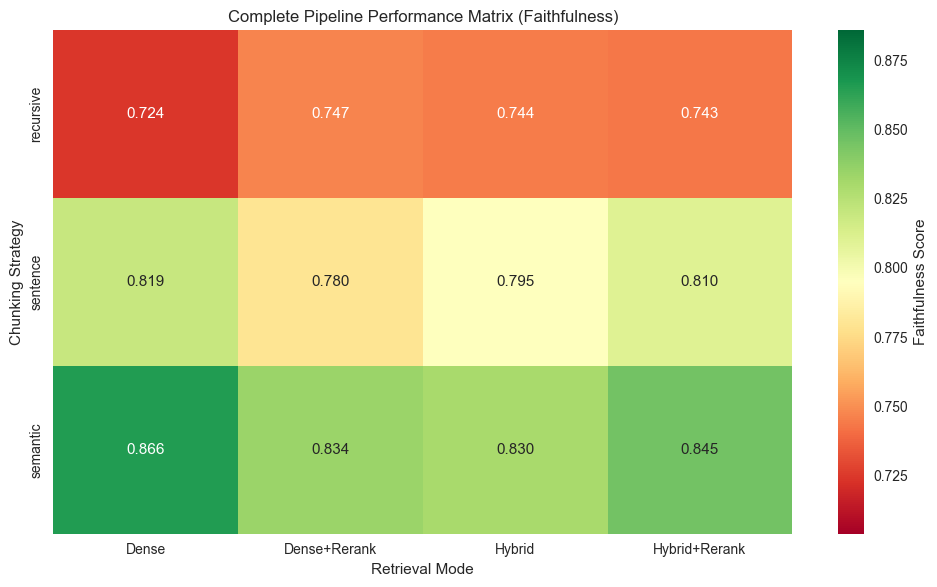

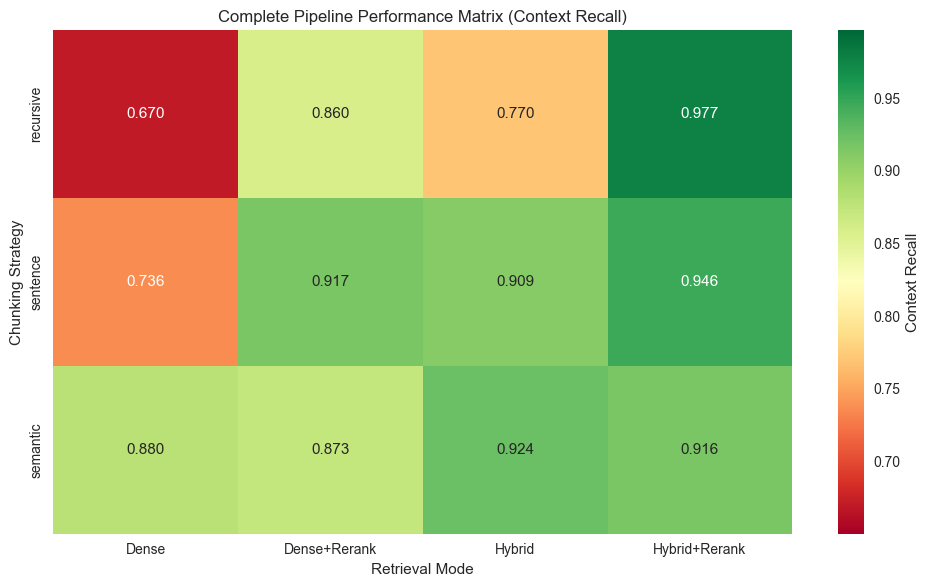


CHUNK-SIZE EXPERIMENT (Recursive Splitter)
                                         faithfulness  answer_relevancy  \
method                       chunk_size                                   
dense_recursive_1000         1000               0.744             0.869   
dense_recursive_1500         1500               0.817             0.813   
dense_recursive_500          500                0.686             0.842   
dense_recursive_rerank_1000  1000               0.750             0.861   
dense_recursive_rerank_1500  1500               0.842             0.840   
dense_recursive_rerank_500   500                0.700             0.844   
hybrid_recursive_rerank_1000 1000               0.728             0.867   
hybrid_recursive_rerank_1500 1500               0.764             0.837   
hybrid_recursive_rerank_500  500                0.735             0.867   

                                         context_precision  context_recall  
method                       chunk_size              

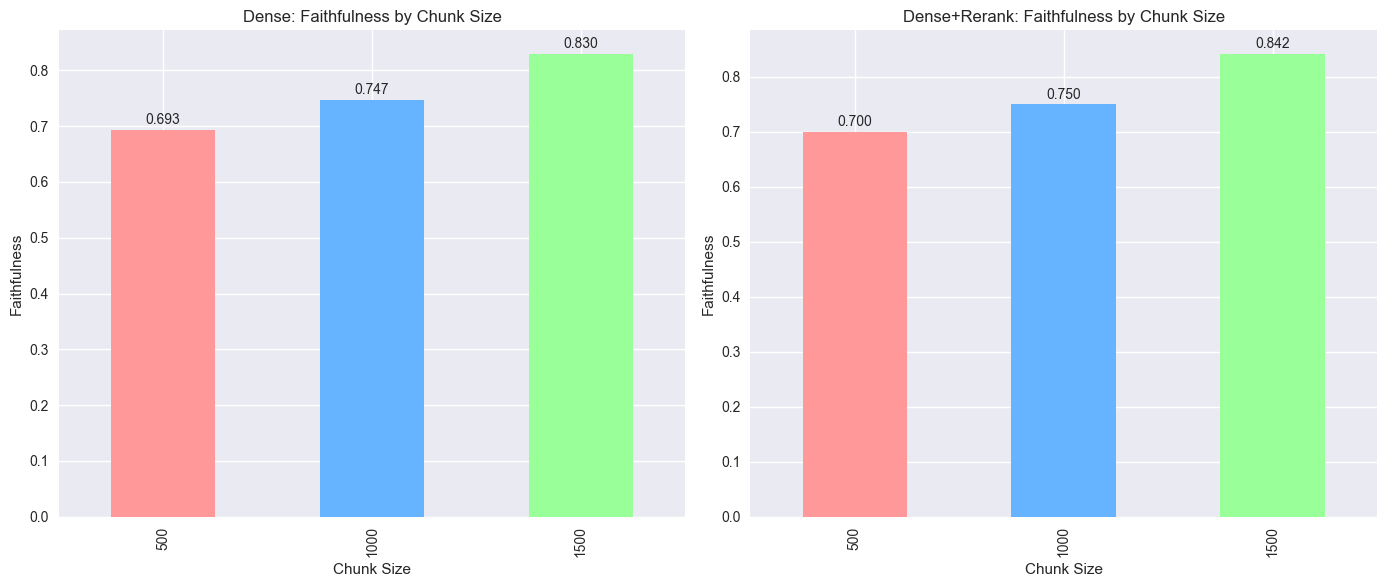

In [22]:
create_component_heatmap()

# === CHUNK-SIZE EXPERIMENT ANALYSIS ===
if len(df_chunk) > 0:
    print("\n" + "=" * 90)
    print("CHUNK-SIZE EXPERIMENT (Recursive Splitter)")
    print("=" * 90)
    
    chunk_summary = df_chunk.groupby('method').agg({
        'faithfulness': 'mean',
        'answer_relevancy': 'mean', 
        'context_precision': 'mean',
        'context_recall': 'mean'
    }).round(3)
    
    # Extract chunk_size from method name or CSV column
    if 'chunk_size' in df_chunk.columns:
        chunk_summary_with_size = df_chunk.groupby(['method', 'chunk_size']).agg({
            'faithfulness': 'mean',
            'answer_relevancy': 'mean',
            'context_precision': 'mean', 
            'context_recall': 'mean'
        }).round(3)
        print(chunk_summary_with_size)
    else:
        print(chunk_summary)
    
    # Plot chunk-size effect on Faithfulness
    if 'chunk_size' in df_chunk.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        for method_pattern, label, ax in [
            ('dense_recursive_', 'Dense', axes[0]),
            ('dense_recursive_rerank_', 'Dense+Rerank', axes[1]),
        ]:
            subset = df_chunk[df_chunk['method'].str.startswith(method_pattern.rstrip('_'))]
            if len(subset) > 0:
                chunk_means = subset.groupby('chunk_size')['faithfulness'].mean()
                chunk_means.plot(kind='bar', ax=ax, color=['#ff9999', '#66b3ff', '#99ff99'])
                ax.set_title(f'{label}: Faithfulness by Chunk Size')
                ax.set_ylabel('Faithfulness')
                ax.set_xlabel('Chunk Size')
                for i, (cs, val) in enumerate(chunk_means.items()):
                    ax.text(i, val + 0.01, f'{val:.3f}', ha='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ No chunk-size experiment data available.")

## 10. LLM COMPARISON (RQ7)
**Does the generator LLM matter? Mistral 7B vs GPT-3.5 vs Phi-3 on the same dense_semantic pipeline.**

Loaded GPT-3.5: 42 rows
Loaded Phi-3: 42 rows

=== TABLE: LLM Generator Comparison (dense_semantic pipeline) ===
               faithfulness  answer_relevancy  context_precision  context_recall  answer_correctness  answer_similarity
generator_llm                                                                                                          
Mistral 7B            0.866             0.882              0.935           0.880               0.528              0.934
GPT-3.5               0.664             0.848              0.857           0.729               0.538              0.878
Phi-3                 0.655             0.743              0.911           0.871               0.529              0.838


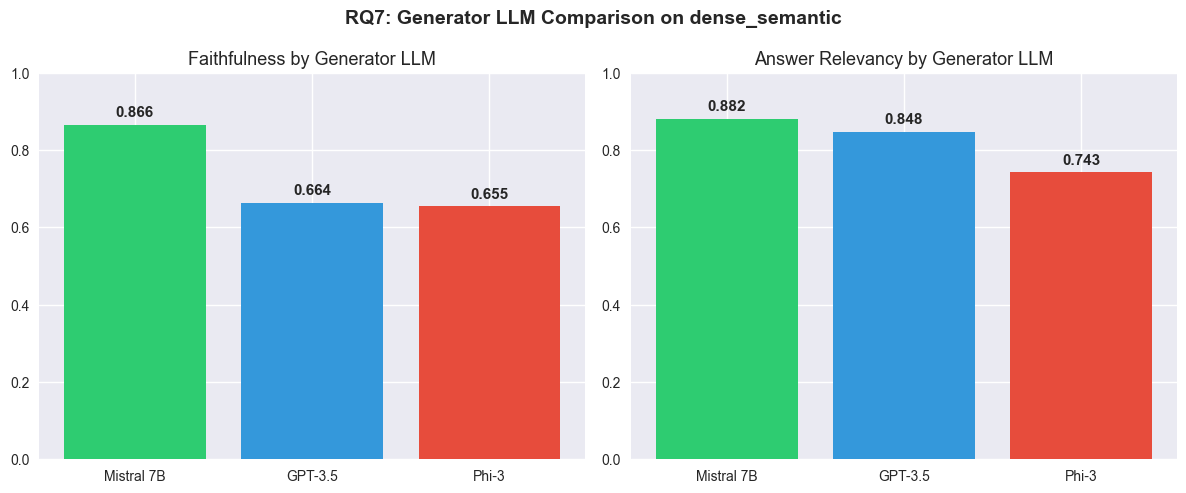

Chart saved.


In [23]:
# === RQ7: LLM COMPARISON ===
import os
llm_dir = f"./results/{CORPUS_NAME}/llm_comparison/"
llm_files = {
    "GPT-3.5": "dense_semantic_gpt35_final_results.csv",
    "Phi-3": "dense_semantic_phi3_final_results.csv",
}

# Load Mistral baseline from main results
mistral_row = df[df["method"] == "dense_semantic"].copy()
mistral_row["generator_llm"] = "Mistral 7B"

# Load GPT-3.5 and Phi-3
llm_frames = [mistral_row]
for label, fname in llm_files.items():
    fpath = os.path.join(llm_dir, fname)
    if os.path.exists(fpath):
        tmp = pd.read_csv(fpath)
        if "semantic_similarity" in tmp.columns:
            tmp = tmp.rename(columns={"semantic_similarity": "answer_similarity"})
        tmp["method"] = "dense_semantic"
        tmp["generator_llm"] = label
        llm_frames.append(tmp)
        print(f"Loaded {label}: {len(tmp)} rows")
    else:
        print(f"NOT FOUND: {fpath}")

df_llm = pd.concat(llm_frames, ignore_index=True)

# === COMPARISON TABLE ===
compare_metrics = ["faithfulness", "answer_relevancy", "context_precision",
                   "context_recall", "answer_correctness", "answer_similarity"]
llm_summary = df_llm.groupby("generator_llm")[compare_metrics].mean()
llm_summary = llm_summary.reindex(["Mistral 7B", "GPT-3.5", "Phi-3"])
print("\n=== TABLE: LLM Generator Comparison (dense_semantic pipeline) ===")
print(llm_summary.round(3).to_string())

# === BAR CHART ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_metrics = ["faithfulness", "answer_relevancy"]
colors = ["#2ecc71", "#3498db", "#e74c3c"]
for idx, metric in enumerate(plot_metrics):
    ax = axes[idx]
    vals = llm_summary[metric]
    bars = ax.bar(vals.index, vals.values, color=colors[:len(vals)])
    ax.set_title(metric.replace("_", " ").title() + " by Generator LLM", fontsize=13)
    ax.set_ylim(0, 1)
    for bar, v in zip(bars, vals.values):
        ax.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.3f}",
                ha="center", fontsize=11, fontweight="bold")
plt.suptitle("RQ7: Generator LLM Comparison on dense_semantic", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(f"./results/{CORPUS_NAME}/llm_comparison_chart.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart saved.")
